# Sparkify Project Notebook

This notebook is prepared for the Sparkify Capstone project needed to complete the Udacity Data Science Nanodegree.

It is intended to be dpeloyed on an Amazon EMR cluster and make use of the full dataset available (12GB).

## 1. Import libraries

In [1]:
from pyspark.sql.functions import udf, min, max, countDistinct
from pyspark.sql.functions import sum as Ssum
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re

from datetime import datetime

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1624275082516_0002,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#Install matplotlib from given PyPI repository
sc.install_pypi_package("matplotlib", "https://pypi.org/simple") 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/24/33/5568d443ba438d95d4db635dd69958056f087e57e1026bee56f959d53f9d/matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/33/34/542152297dcc6c47a9dcb0685eac6d652d878ed3cea83bf2b23cb988e857/Pillow-8.2.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d2/46/231de802ade4225b76b96cffe419cf3ce52bbe92e3b092cf12db7d11c207/kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl

In [3]:
# Check installation
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
beautifulsoup4             4.9.3    
boto                       2.49.0   
click                      7.1.2    
cycler                     0.10.0   
jmespath                   0.10.0   
joblib                     1.0.1    
kiwisolver                 1.3.1    
lxml                       4.6.2    
matplotlib                 3.4.2    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
Pillow                     8.2.0    
pip                        9.0.1    
py-dateutil                2.2      
pyparsing                  2.4.7    
python-dateutil            2.8.1    
python37-sagemaker-pyspark 1.4.1    
pytz                       2021.1   
PyYAML                     5.4.1    
regex                      2021.3.17
setuptools                 28.8.0   
six                        1.13.0   
tqdm                       4.59.0   
w

In [5]:
# Import
from matplotlib import pyplot as plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Load and Clean Dataset

In [6]:
# Define path
# Mini dataset
# path = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
# Full dataset
path ="s3n://udacity-dsnd/sparkify/sparkify_event_data.json"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Load & Persist data
df_user_log = spark.read.json(path)
df_user_log.persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [8]:
# Check schema
df_user_log.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [9]:
# Show the first row
df_user_log.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

In [11]:
# Check num of rows, columns
print('Number of rows: ', df_user_log.count(), '; Number of columns: ', len(df_user_log.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows:  26259199 ; Number of columns:  18

We can eliminate `NaN` in `userId` or `sessionId`, and cases of empty users too: 

In [16]:
# Drop NaN
df_user_log_valid = df_user_log.dropna(how = "any", subset = ["userId", "sessionId"])
# Drop empty users
df_user_log_valid = df_user_log_valid.filter(df_user_log_valid["userId"] != "")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# Check updated num of rows, columns
print('Number of rows: ', df_user_log_valid.count(), '; Number of columns: ', len(df_user_log_valid.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows:  26259199 ; Number of columns:  18

## 3. Define Churn variable

In [12]:
# Check available pages
df_user_log.select("page").dropDuplicates().sort("page").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows

In [18]:
# Defining a churn variable based on the Cancellation Confirmation page
cancellation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())  
df_user_log_valid = df_user_log_valid.withColumn("churn", cancellation("page"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
# show column
df_user_log_valid.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042', churn=0)

In [20]:
# Create a list of users that cancelled vs. users that stayed
users_cancelled = df_user_log_valid.select(["userId"]).where(df_user_log_valid.churn == 1).dropDuplicates().collect()
users_staying = df_user_log_valid.select(["userId"]).where(df_user_log_valid.churn == 0).dropDuplicates().collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
print('Num. of users that cancelled: ', len(users_cancelled), '; Num. of users staying: ', len(users_staying))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Num. of users that cancelled:  5003 ; Num. of users staying:  22278

In [22]:
# Select a subset of the dataframe with the users that left
users_cancelled_list = [us_c[0] for us_c in users_cancelled]
df_user_log_cancelled = df_user_log_valid.filter(df_user_log_valid.userId.isin(users_cancelled_list))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# Select a subset of the dataframe with the users that are staying
users_staying_list = [us_s[0] for us_s in users_staying]
df_user_log_staying = df_user_log_valid.filter(df_user_log_valid.userId.isin(users_staying_list))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# Check dta frames sizes
print('# of Rows of the dataframe of users that cancelled: ', df_user_log_cancelled.count())
print('# of Rows of the dataframe of users that are staying: ', df_user_log_staying.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# of Rows of the dataframe of users that cancelled:  5382467
# of Rows of the dataframe of users that are staying:  26259199

## 4. Data exploration

### 4.1. Number of days spent, Number of songs per day

Let's take a look at the time spent with the service, and the number of songs listened per day.  

For each user, we'll calculate the number of days based on the first and last timestamp, and then divine the number of songs for the number of days.

**Cancelling Users**

In [27]:
# Select, for every user that cancelled, the number of songs and the time span they spent with the service
song_time_canc = df_user_log_cancelled.\
                filter(df_user_log_cancelled["song"] != "").\
                groupBy("userId").\
                agg(min("ts"), max("ts"), countDistinct("song")).\
                collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
# Get the time difference
delta_time_cancelled = [(song_time[2]/1000 - song_time[1]/1000)/(3600*24) for song_time in song_time_canc]
# Get the number of songs listened per day day (on average)
# NOTE: the if clause is neede for the use case in which a user has listened to just one song before leaving, and so 
# there would be only one timestamp associated with the event
num_songs_cancelled = [song_time[3]/((song_time[2]/1000 - song_time[1]/1000)/(3600*24)) \
                       if ((song_time[2]/1000 - song_time[1]/1000)/(3600*24)) \
                       else 1.0 for song_time in song_time_canc]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

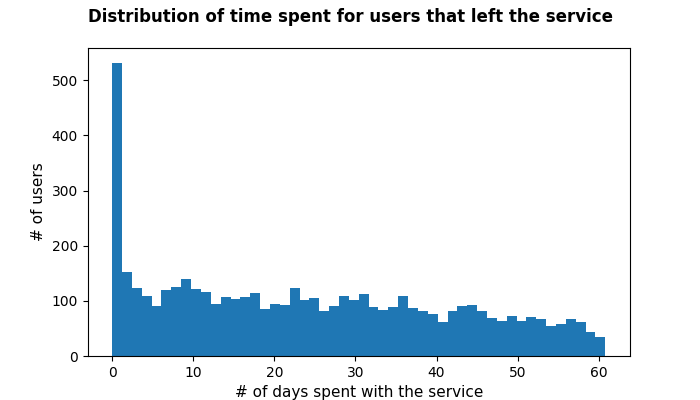

In [73]:
# Plot histogram fot time
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of time spent for users that left the service', fontsize=12, fontweight='bold');

plt.hist(delta_time_cancelled, bins=50);
plt.xlabel('# of days spent with the service', fontsize=11);
plt.ylabel('# of users', fontsize=11);

%matplot plt

In [74]:
# Look at the statistics
print('Statistics for time spent with the service for users that stayed:')
spark.createDataFrame(delta_time_cancelled, FloatType()).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Statistics for time spent with the service for users that stayed:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|              5002|
|   mean|24.236902227921572|
| stddev|17.690378886277752|
|    min|               0.0|
|    max|          60.82044|
+-------+------------------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

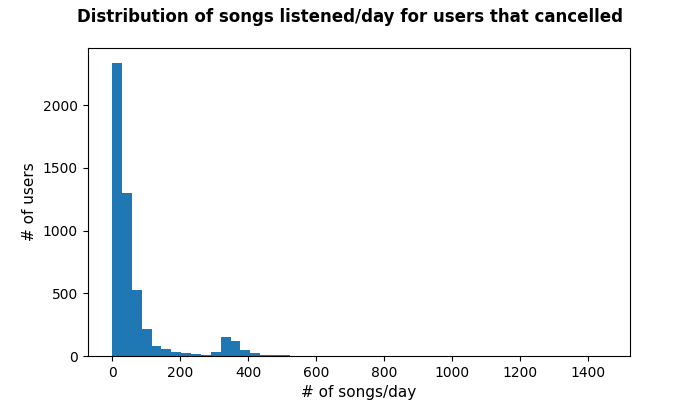

In [75]:
# Plot histogram for songs
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of songs listened/day for users that cancelled', fontsize=12, fontweight='bold');

plt.hist(num_songs_cancelled, bins=50);
plt.xlabel('# of songs/day', fontsize=11);
plt.ylabel('# of users', fontsize=11);

%matplot plt

In [76]:
# Look at the statistics
print('Statistics for songs/day for users that cancelled:')
spark.createDataFrame(num_songs_cancelled, FloatType()).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Statistics for songs/day for users that cancelled:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|              5002|
|   mean| 67.22089404627377|
| stddev|101.09707031180494|
|    min|         0.2437962|
|    max|         1452.1008|
+-------+------------------+

**Users Staying**

In [77]:
# Select, for every user that stays, the number of songs and the time span they spent with the service
song_time_stay = df_user_log_staying.\
                filter(df_user_log_staying["song"] != "").\
                groupBy("userId").\
                agg(min("ts"), max("ts"), countDistinct("song")).\
                collect()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
# Get the time difference
delta_time_staying = [(song_time[2]/1000 - song_time[1]/1000)/(3600*24) for song_time in song_time_stay]
# Get the number of songs listened per day day (on average)
# NOTE: the if clause is neede for the use case in which a user has listened to just one song before leaving, and so 
# there would be only one timestamp associated with the event
num_songs_staying = [song_time[3]/((song_time[2]/1000 - song_time[1]/1000)/(3600*24)) \
                       if ((song_time[2]/1000 - song_time[1]/1000)/(3600*24)) \
                       else 1.0 for song_time in song_time_stay]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

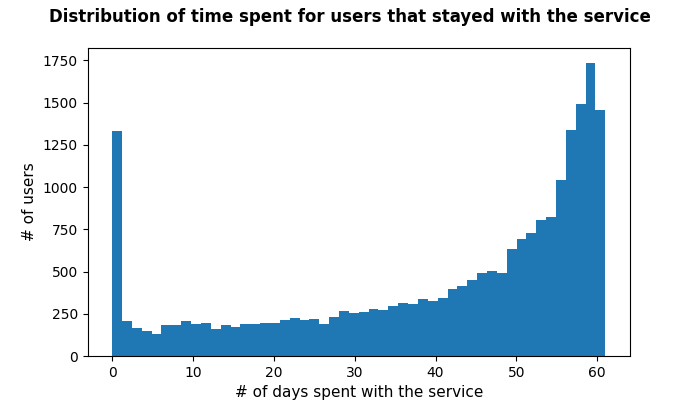

In [79]:
# Plot histogram for time
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of time spent for users that stayed with the service', fontsize=12, fontweight='bold');

plt.hist(delta_time_staying, bins=50);
plt.xlabel('# of days spent with the service', fontsize=11);
plt.ylabel('# of users', fontsize=11);

%matplot plt

In [80]:
# Look at the statistics
print('Statistics for time spent with the service for users that stayed:')
spark.createDataFrame(delta_time_staying, FloatType()).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Statistics for time spent with the service for users that stayed:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|             22261|
|   mean|40.675792643424835|
| stddev|18.985476279836412|
|    min|               0.0|
|    max|         60.999504|
+-------+------------------+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

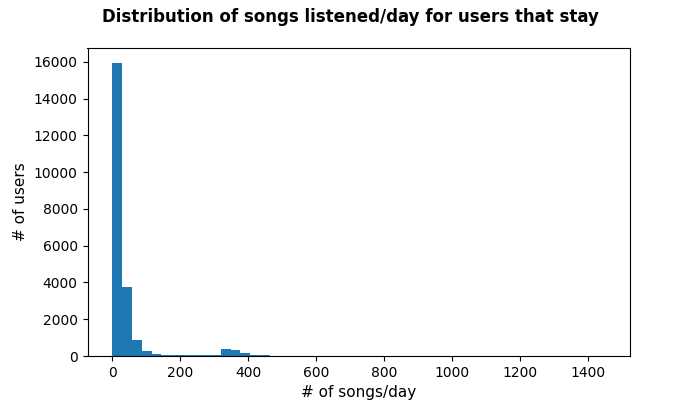

In [81]:
# Plot histogram for the songs
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of songs listened/day for users that stay', fontsize=12, fontweight='bold');

plt.hist(num_songs_staying, bins=50);
plt.xlabel('# of songs/day', fontsize=11);
plt.ylabel('# of users', fontsize=11);

%matplot plt

In [82]:
# Look at the statistics
print('Statistics for songs/day for users that stay:')
spark.createDataFrame(num_songs_staying, FloatType()).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Statistics for songs/day for users that stay:
+-------+-----------------+
|summary|            value|
+-------+-----------------+
|  count|            22261|
|   mean|40.91689135214914|
| stddev|85.38924711704384|
|    min|      0.103192024|
|    max|        1452.1008|
+-------+-----------------+